# Saving surface densities to pickle files
<p>The density projection, also known as the surface density, is the integral of density along the z direction: $ \Sigma = \int{\rho dz}$</p> 

In [1]:
import pyathena as pa
import sys
import os
import os.path as osp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statistics
import xarray as xr
import _pickle as pickle
import astropy.constants as c
import astropy.units as u

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll

sys.path.insert(0,'..')

In [2]:
models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/')#,
              #demo = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y2.xy1024.eps0.np768.has/')
sa = pa.LoadSimTIGRESSNCRAll(models)

In [3]:
sa.models


['classic', 'ncr', 'no_spiral']

In [27]:
# MODELS

ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')

s = classic

units=s.u
print(units.muH)
print(units.density.cgs/units.muH/c.m_p.cgs, units.velocity, units.length)
print(units.mass,units.time)


1.4
1.0007183066452634 1 / cm3 1.0 km / s 1.0 pc
0.0346244904274392 solMass 30856775814913.676 s


In [28]:
print(s.nums[0])
print(s.nums[-1])

210
470


In [6]:
codemass=units.mass
codetime=units.Myr 
codelength=units.length
print(codemass,codetime,codelength)

0.0346244904274392 solMass 0.9777922216807893 1.0 pc


In [29]:
datanumslist = ['210','220','230','240','250','260','270','280','290','300','310','320','330','340','350','360','370','380','390',
               '400','410','420','430','440','450','460','470']
for i in range (27):
    datanums = datanumslist[i]
    
    ds = s.load_vtk(num=s.nums[i])
    field = ds.get_field(['density'])
    sigma = np.trapz(field['density'],axis=0)
    sigma_dict = {
      "bounds": [- s.domain['Lx'][0]/2, s.domain['Lx'][0]/2, - s.domain['Lx'][1]/2, s.domain['Lx'][1]/2],
      "data": sigma
    }

    #with open('surf/R8_8pc_NCRSP_spiral_ncr.0'+datanums+'.surf.p','wb') as f:
    with open('surf/R8_8pc_NCRSP_spiral_classic.0'+datanums+'.surf.p','wb') as f:
    #with open('surf/R8_8pc_NCRSP_ncr.0'+datanums+'.surf.p','wb') as f:
        pickle.dump(sigma_dict, f)

In [30]:
len(datanumslist)

27

In [37]:
# this line choses a particular file:
surf_file='surf/R8_8pc_NCRSP_spiral_classic.0210.surf.p'

# this line reads in the binary file to 'surf'
surf=pickle.load(open(surf_file,'rb'))

In [38]:
# "surf" is a dictionary, containing XY domain boundaries and density projection as a numpy array.
print(surf['bounds'])
# to get data dimensions,
print(surf['data'].shape)

[-1024.0, 1024.0, -1024.0, 1024.0]
(256, 256)


In [39]:
# Since we are using a uniform grid, grid resolution is simply given by
Lx=surf['bounds'][1]-surf['bounds'][0]
Ly=surf['bounds'][3]-surf['bounds'][2]
Ny,Nx=surf['data'].shape

# Again, the lengths are in unit of parsec
dx=Lx/Nx
dy=Ly/Ny

In [40]:
# Surface density is already calculated in units of M_sun/pc^2
print(surf['data'].mean())

37.853306


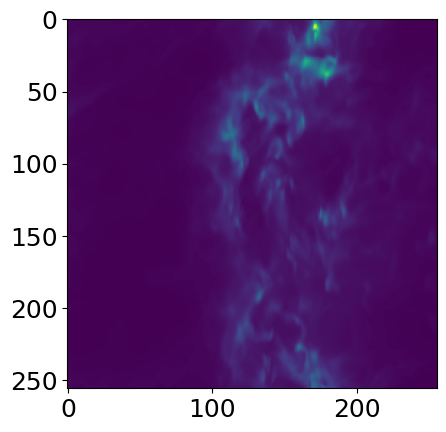

In [41]:
# Let's simply plot it
plt.imshow(surf['data'])

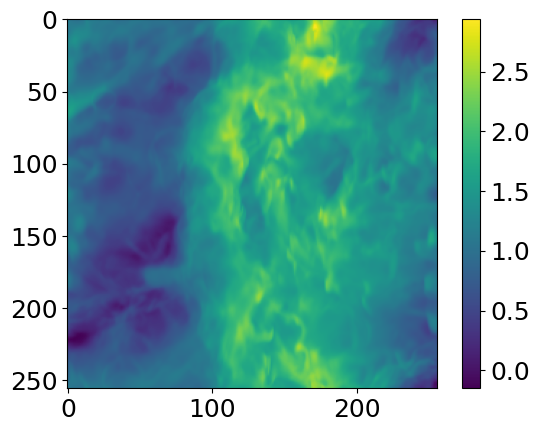

In [42]:
# It may be better to draw in log-scale.
# There are two ways to do it.
# You can take log10 of the data directly,
im=plt.imshow(np.log10(surf['data']))
plt.colorbar(im)

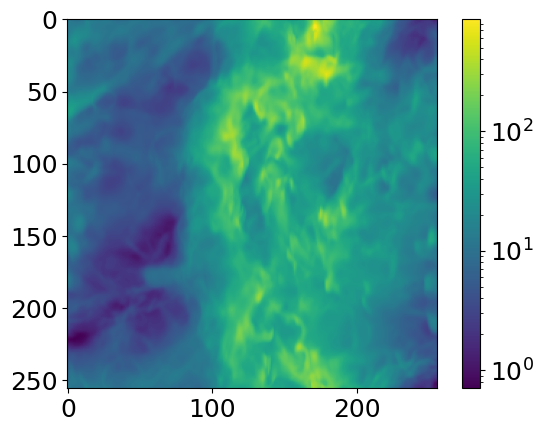

In [43]:
# or you can change the colorbar to log-scale.
# We usually prefer this method.
im=plt.imshow(surf['data'],norm=LogNorm())
plt.colorbar(im)

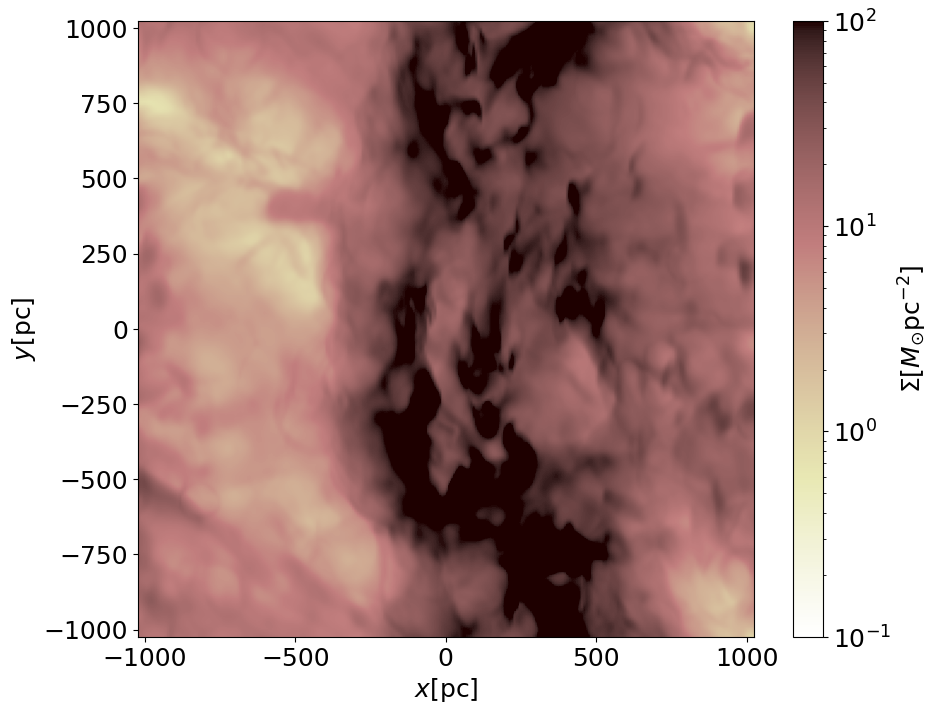

In [44]:
# please see this code to learn how to handle origin, range of the image, and color map

plt.rcParams['font.size']=18
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
im=ax.imshow(surf['data'],norm=LogNorm(),origin='lower')
im.set_clim(1.e-1,1.e2)
im.set_extent(surf['bounds'])
im.set_cmap(plt.cm.pink_r)
ax.set_xlabel(r'$x [{\rm pc}]$')
ax.set_ylabel(r'$y [{\rm pc}]$')
cbar=plt.colorbar(im)
cbar.set_label(r'$\Sigma [M_{\odot} {\rm pc}^{-2}]$')

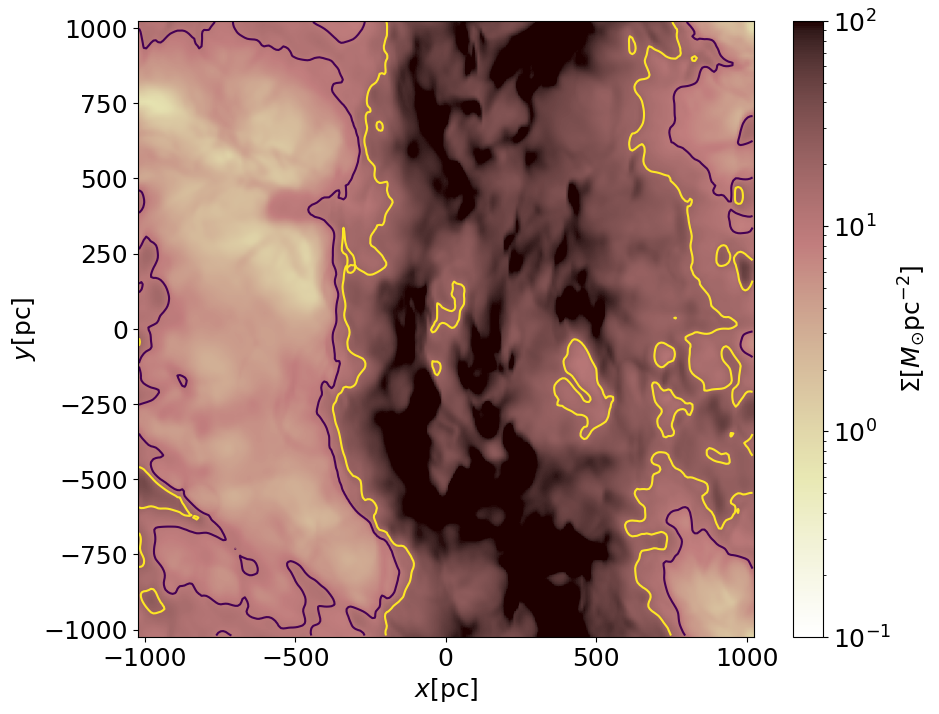

In [45]:
# set cell centered coordinates
x=np.arange(surf['bounds'][0],surf['bounds'][1],dx)+0.5*dx
y=np.arange(surf['bounds'][2],surf['bounds'][3],dy)+0.5*dy
X, Y = np.meshgrid(x,y)

# overplot contour at Surface density of 10 and 20
ct=ax.contour(X,Y,surf['data'],[10,20])
fig

In [46]:
# we have star particles, representing star clusters and runaway OB stars
# the star particle information is stored in the *.starpar.vtk files

# note that you must be sure to read the star particle file from the SAME time snapshot as the 
# gas surface density file
sp=s.load_starpar_vtk(num=210)

In [47]:
# star particle data include age, velocity, position, mass, time, and id
# note that they are all in code units, so proper unit conversion may be needed
sp.keys()

Index(['id', 'flag', 'n_ostar', 'mass', 'age', 'mage', 'metal_mass[0]',
       'metal_mass[1]', 'metal_mass[2]', 'metal_mass[3]', 'metal_mass[4]',
       'x1', 'x2', 'x3', 'v1', 'v2', 'v3'],
      dtype='object')

In [48]:
#this is the time for the snapshot
print(sp.time*codetime)
#these are attributes for star particle #20:
print(sp.mass[20]*codemass, sp.age[20]*codetime,sp.x1[20]*codelength,sp.x2[20]*codelength)

205.3374421244096
19866.394327141814 solMass 208.56697796898962 241.3194122314453 pc 97.05772399902344 pc


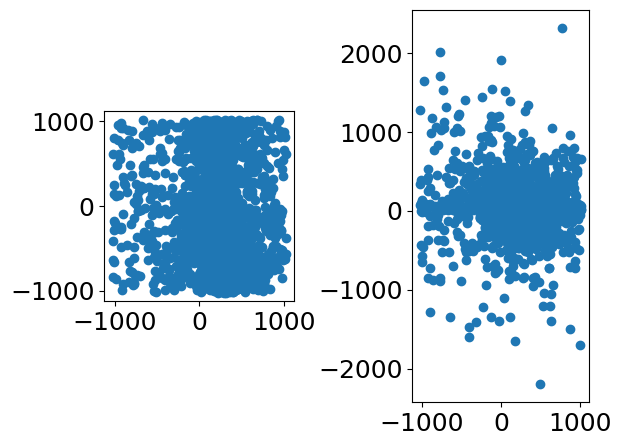

In [49]:
# Let's plot star particles
# these are positions projected onto the horizontal plane:
plt.subplot(121,aspect='equal')
plt.plot(sp['x1'],sp['x2'],'o')
# these are positions projected onto the radial-vertical plane
plt.subplot(122,aspect='equal')
plt.plot(sp['x1'],sp['x3'],'o')
plt.tight_layout()

0.9777922216807893
2034 2034
1610
73 1537


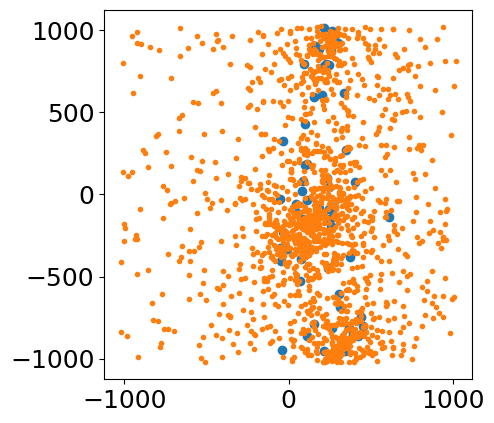

In [50]:
# select young star particles (age < 40Myr)
# first, we need the code unit of time in Myr
tunit_Myr=units.time.to('Myr').value
print(tunit_Myr)
# "young" is a boolean array: True for young, False for old
young=sp['age'] * tunit_Myr < 40.

print(len(sp['age']),len(young))
print(young.sum())

# second, separate clusters (mass != 0) and runaways (mass == 0)
# mass of runaway OB stars was set to zero
# "runaway" and "cluster" are also boolean arrays
runaway=sp['mass'] == 0
cluster=sp['mass'] != 0

# young * cluster is True for young and cluster particles
young_cluster = young & cluster

print(young_cluster.sum(),runaway.sum())

plt.subplot(111,aspect='equal')
plt.plot(sp['x1'][young_cluster],sp['x2'][young_cluster],'o')
plt.plot(sp['x1'][runaway],sp['x2'][runaway],'.')

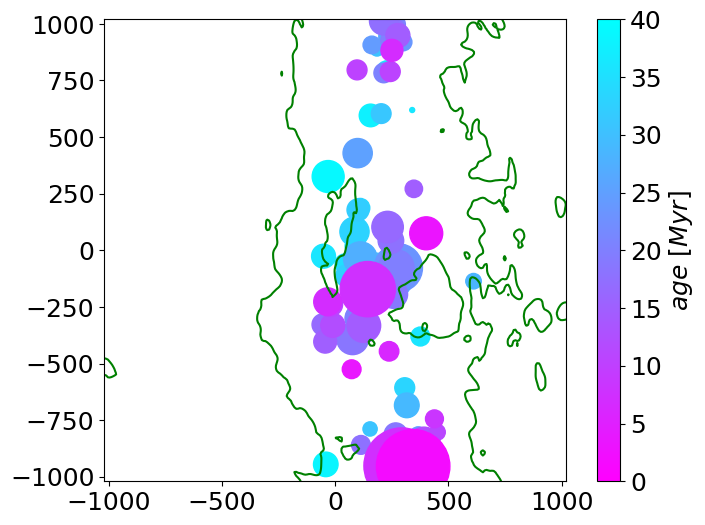

In [51]:
# using scatter plot, we can set size and color cluster particles based on their mass and age, respectively.
# let's convert mass and age in Msun and Myr, respectively.
munit_Msun=units.mass.to('Msun').value
mass=sp['mass'][young_cluster]*munit_Msun
age=sp['age'][young_cluster]*tunit_Myr

plt.figure(figsize=(8,6))
ax=plt.subplot(111,aspect='equal')
sc=ax.scatter(sp['x1'][young_cluster],sp['x2'][young_cluster],marker='o',s=mass/50.,c=age,
           vmax=40,vmin=0,cmap=plt.cm.cool_r)
#plt.plot(sp['x1'][runaway],sp['x2'][runaway],'.k')
cbar=plt.colorbar(sc)
cbar.set_label(r'$age\ [Myr]$')
# overplot contour at Surface density of 30
ct=ax.contour(X,Y,surf['data'],[30],colors=('green'))